In [1]:
import pandas as pd
import numpy as np
import scipy.stats as st
import seaborn as sns
import sys
import os
import gseapy as gp
import matplotlib.pyplot as plt
import swan_vis as swan
import yaml
from snakemake.io import expand

p = os.path.dirname(os.path.dirname(os.getcwd()))
sys.path.append(p)

from proc_revisions.utils import *
from proc_revisions.mane_utils import *
from proc_revisions.plotting import *

In [2]:
od = '../../proc_revisions/'
config_file = f'{od}/config.yml'
with open(config_file) as f:
    config = yaml.safe_load(f)

In [3]:
ab = od+expand(config['lr']['talon']['fusion_fix']['ab'], species='human')[0]
filt_ab = od+expand(config['lr']['cerberus']['filt_ab'], species='human')[0]
read_annot = od+expand(config['lr']['talon']['full_annot'], species='human')[0]
t_metadata = od+expand(config['ref']['cerberus']['new_gtf_t_info'], species='human')[0]
lib_meta = od+expand(config['lr']['meta'], species='human')[0]
swan_file = od+expand(config['lr']['swan']['sg'], species='human')[0]
cerberus_h5 = od+expand(config['lr']['cerberus']['ca_triplets'], species='human', obs_col='sample')[0]
cerb_t_metadata = od+expand(config['lr']['cerberus']['gtf_t_info'], species='human')[0]
major_isos = od+expand(config['lr']['analysis']['major_isos'], species='human', obs_col='sample')[0]
pi_tpm_table = od+expand(config['lr']['mane']['pi_tpm']['triplet'], species='human', obs_col='sample')[0]
dataset_exp_gene = od+expand(config['lr']['mane']['exp_gene_subset'], species='human', obs_col='dataset')[0]
sample_exp_gene = od+expand(config['lr']['mane']['exp_gene_subset'], species='human', obs_col='sample')[0]



ref_t_metadata = od+expand(config['ref']['new_gtf_t_info'], species='human')[0]
ref_g_metadata = od+expand(config['ref']['new_gtf_g_info'], species='human')[0]

# pp_summary = '../'+expand(config['data']['p_pred']['summary'], species='human')[0]

m_lib_meta = od+expand(config['lr']['meta'], species='mouse')[0]

# orf_fa = '../'+expand(config['data']['p_pred']['orf_fa'], species='human')[0]
# pp_bed = '../'+expand(config['data']['p_pred']['cds_bed'], species='human')[0]

ver = 'v40_cerberus'
min_tpm = 1
gene_subset = 'protein_coding'
obs_col = 'sample'
go_gene_subset = 'protein_coding'


# Figures 4 and S11

## MANE analyses using libraries

Read in graph from ../../proc_revisions/data/human/lr/swan/swan_graph.p
triplet
# genes: 16816
68.57% (11531/16816) of genes have a non-MANE predominant triplet in 80% of expressed datasets
14.38% of genes (2418/16816) have predom == mane in all datasets
28.28% of genes (4756/16816) have predom != mane in all datasets
32.87% (291184/885967) ranked gene / library combinations where predominant isoform is not MANE
72.90% (433602/594783) of gene / dataset combos where MANE is predominant triplet also have a secondary expressed triplet
33.74% (255313/756666) of gene / dataset combos  where predominant triplet is not MANE have MANE expression
66.26% (501353/756666) of gene / dataset combos  where predominant triplet is not MANE have NO MANE expression
85.62% (14398/16816) of genes have >= 1 dataset where the predominant triplet is not MANE
71.72% (12060/16816) of genes have >= 1 dataset where the predominant triplet is MANE

tss
# genes: 16819
27.12% (4561/16819) of genes have a non-MANE pr

/Users/fairliereese/Documents/programming/mortazavi_lab/data/paper_rnawg/proc_revisions/mane_utils.py:331: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  plt.figure(figsize=figsize)


13.09% (151921/1160534) ranked gene / library combinations where predominant IC is not MANE
63.82% (643725/1008613) of gene / dataset combos where MANE is predominant ic also have a secondary expressed ic
37.47% (132306/353142) of gene / dataset combos  where predominant ic is not MANE have MANE expression
62.53% (220836/353142) of gene / dataset combos  where predominant ic is not MANE have NO MANE expression
70.08% (11784/16816) of genes have >= 1 dataset where the predominant ic is not MANE
90.39% (15200/16816) of genes have >= 1 dataset where the predominant ic is MANE

tes
# genes: 16817
46.95% (7895/16817) of genes have a non-MANE predominant tes in 80% of expressed datasets
37.07% of genes (6234/16817) have predom == mane in all datasets
15.14% of genes (2546/16817) have predom != mane in all datasets
25.30% (275513/1089177) ranked gene / library combinations where predominant TES is not MANE
32.70% (266061/813664) of gene / dataset combos where MANE is predominant tes also have

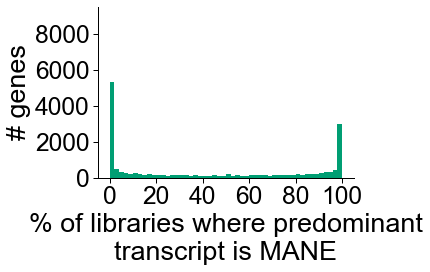

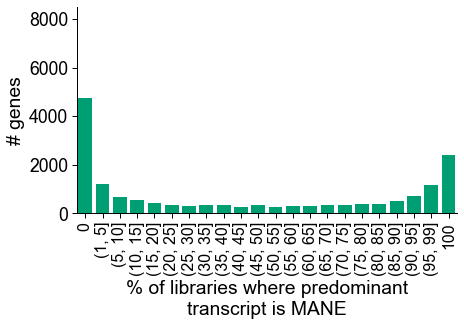

<Figure size 288x324 with 0 Axes>

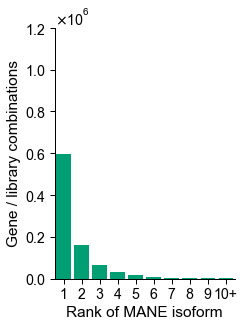

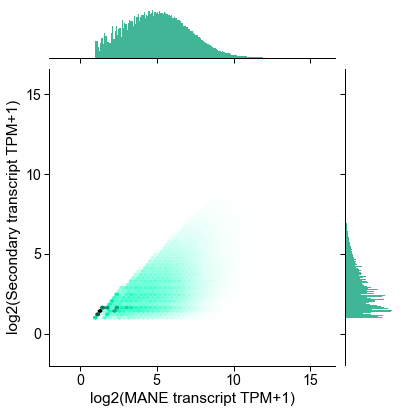

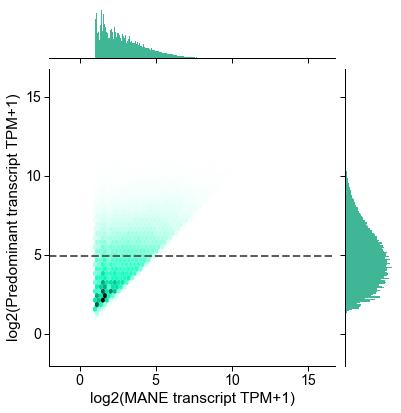

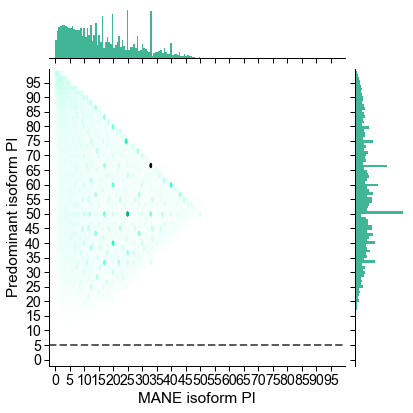

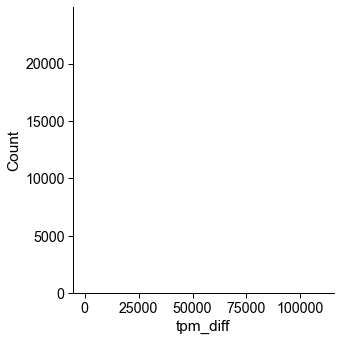

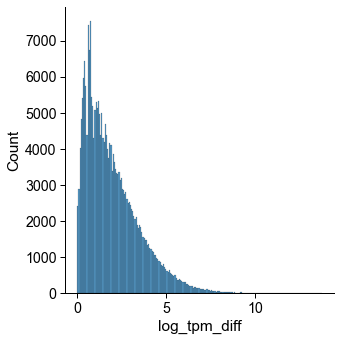

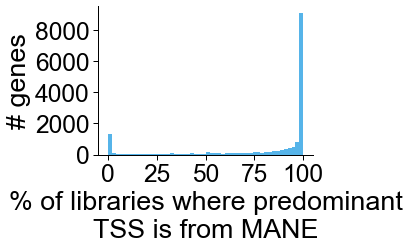

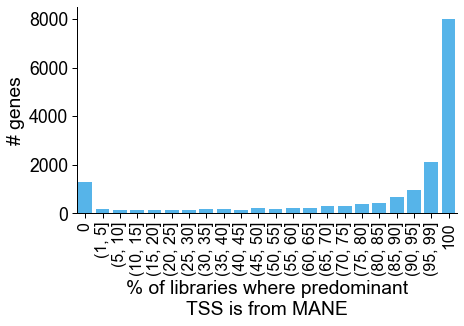

<Figure size 288x324 with 0 Axes>

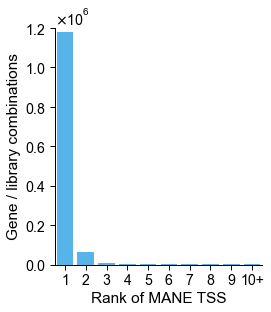

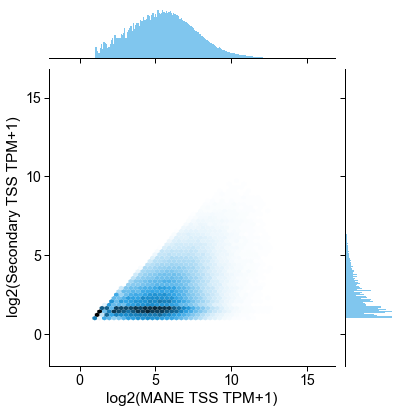

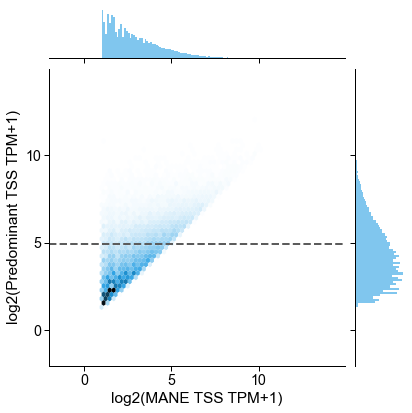

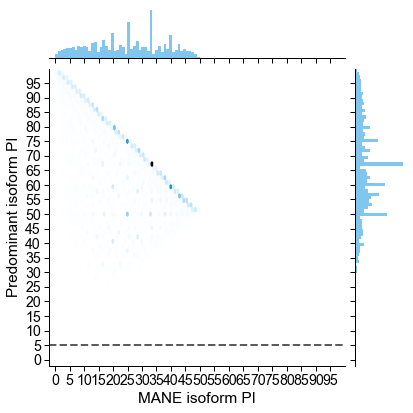

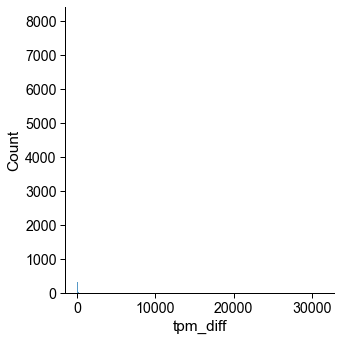

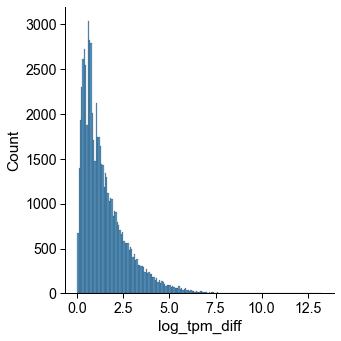

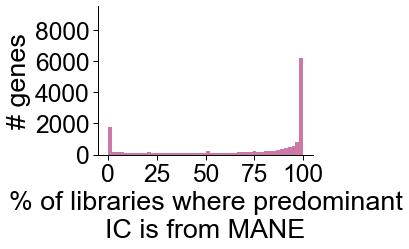

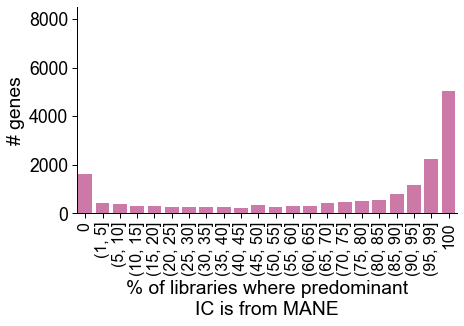

<Figure size 288x324 with 0 Axes>

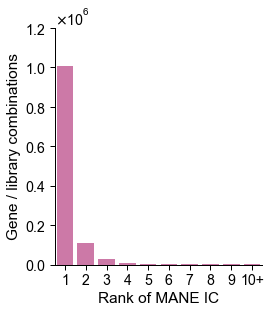

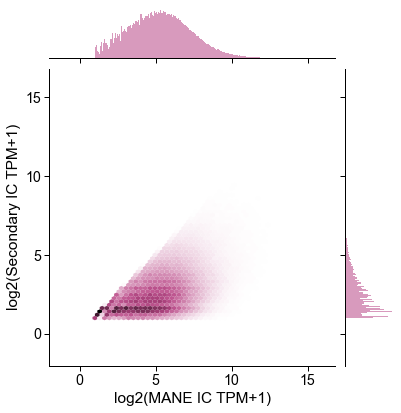

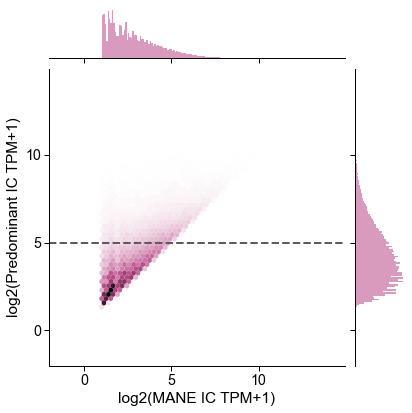

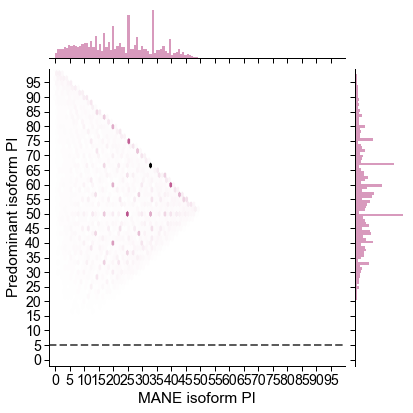

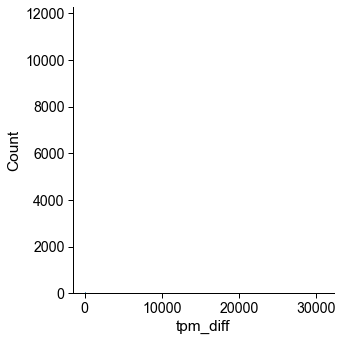

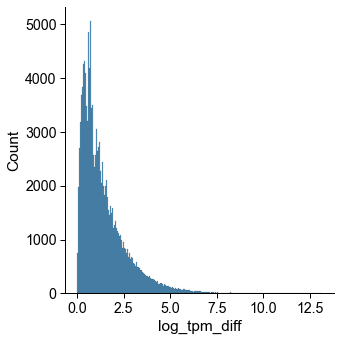

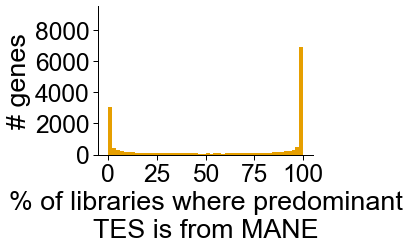

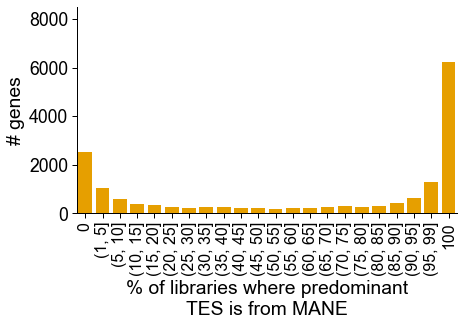

<Figure size 288x324 with 0 Axes>

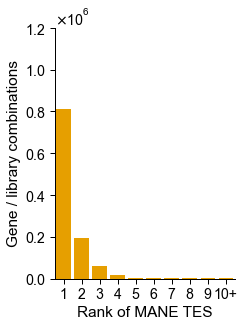

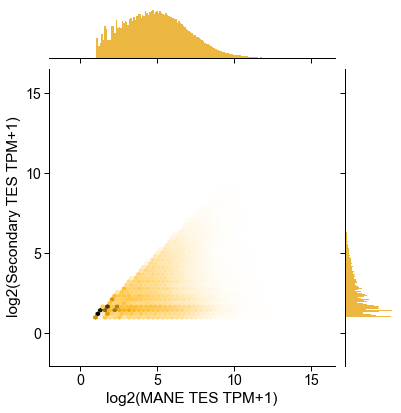

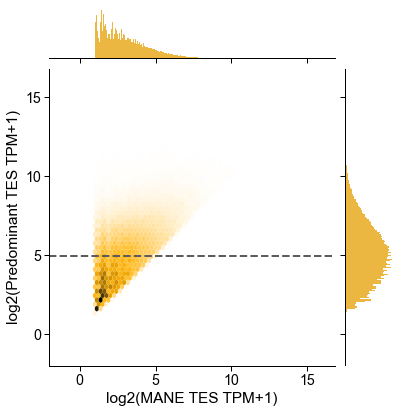

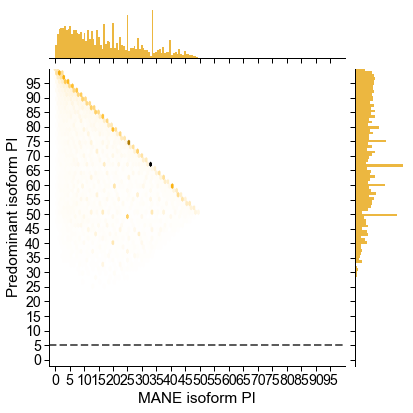

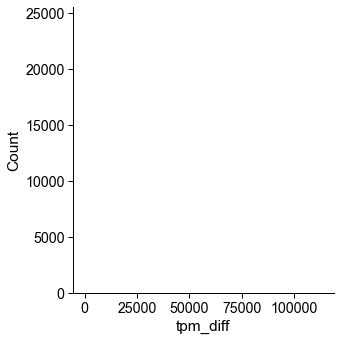

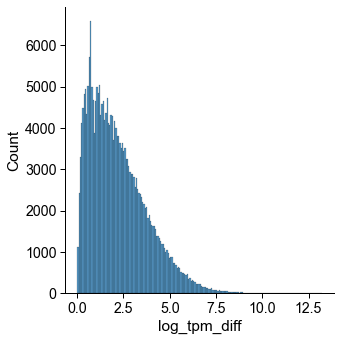

In [4]:
sg = swan.read(swan_file)
ca = cerberus.read(cerberus_h5)
mp_dfs = mane_analysis(sg, ca, 
                       ref_t_metadata,
                       ref_g_metadata,
                       'dataset',
                       min_tpm,
                       dataset_exp_gene,
                       config['lr']['mane']['pi_tpm'])

In [5]:
# get mane and non-mane intron chain IDs
df = mp_dfs['ic']

nm_df = df.loc[df.ic_princ_is_mane==False].copy(deep=True)[['ic_id_princ']].drop_duplicates()
nm_df.rename({'ic_id_princ': 'Name'}, axis=1, inplace=True)
nm_df = cerberus.split_cerberus_id(nm_df, 'ic')

In [6]:
mane_df = nm_df[['gene_id']].drop_duplicates()
mane_df['Name'] = mane_df['gene_id']+'_'+'1'

In [7]:
# get ic coords for each non mane predom ic and for mane ics
ca = cerberus.read(cerberus_h5)

In [8]:
ic_df = ca.ic.copy(deep=True)
ic_df.drop('gene_id', axis=1, inplace=True)
nm_df = nm_df.merge(ic_df, how='left', on='Name')
mane_df = mane_df.merge(ic_df, how='left', on='Name')

In [9]:
nm_df = nm_df[['Name', 'Coordinates', 'novelty', 'gene_id']]
mane_df = mane_df[['Name', 'Coordinates', 'gene_id']]
df = nm_df.merge(mane_df, on=['gene_id'], how='left', suffixes=('_predom', '_mane'))

In [10]:
# remove unspliced transcripts as definitionally they cannot
df['predom_subset_of_mane'] = df.apply(lambda x: x['Coordinates_predom'] in x['Coordinates_mane'] and x['Coordinates_predom'] != '-', axis=1)

In [11]:
temp = df[['Name_predom', 'predom_subset_of_mane']].groupby('predom_subset_of_mane').count().reset_index()
n = len(nm_df)
n_num = temp.loc[temp.predom_subset_of_mane==True, 'Name_predom'].values[0]
print(f'{(n_num/n)*100:.2f}% of non-mane predom ICs ({n_num}/{n}) are partial splice matches to MANE ICs')

30.68% of non-mane predom ICs (10301/33580) are partial splice matches to MANE ICs


In [12]:
temp = df[['Name_predom', 'novelty', 'predom_subset_of_mane']].groupby(['predom_subset_of_mane', 'novelty']).count().reset_index()
n_num_2 = temp.loc[(temp.novelty=='Known')&(temp.predom_subset_of_mane==True), 'Name_predom'].values[0]
print(f'{(n_num_2/n_num)*100:.2f}% of non-MANE subset predom ICs ({n_num_2}/{n_num}) are annotated')

56.71% of non-MANE subset predom ICs (5842/10301) are annotated


In [13]:
## how often are non-mane predominant isoforms from mane clinical?

In [14]:
df = mp_dfs['triplet']

In [15]:
# get list of non-mane predom tids
df = df[['tid_princ']].drop_duplicates()
df = df.rename({'tid_princ': 'predom_tid'}, axis=1)
df['gid'] = df.predom_tid.str.split('[', n=1, expand=True)[0]

In [16]:
gtf_df, _, _ = get_gtf_info(how='iso', ver='v40_cerberus')

In [17]:
# get all mane tids, including select and plus clinical
mane_tids = gtf_df.loc[(gtf_df.MANE_Select==True)].tid.tolist()
print(len(mane_tids))
mane_tids = gtf_df.loc[(gtf_df.MANE_Select==True)|(gtf_df.MANE_Plus_Clinical==True)].tid.tolist()
print(len(mane_tids))
df['not_mane'] = ~df.predom_tid.isin(mane_tids)

18600
18656


In [18]:
temp = df[['gid', 'not_mane']].groupby('gid').any().reset_index().groupby('not_mane').count().reset_index()
n = temp['gid'].sum()
n_num = temp.loc[temp.not_mane==True, 'gid'].values[0]
print(f'{(n_num/n)*100:.2f}% of MANE genes ({n_num}/{n}) have >=1 library where predom iso != MANE')

85.61% of MANE genes (14396/16816) have >=1 library where predom iso != MANE


In [19]:
temp = df[['gid', 'not_mane']].groupby('gid').any().reset_index().groupby('not_mane').count().reset_index()
n = temp['gid'].sum()
n_num = temp.loc[temp.not_mane==True, 'gid'].values[0]
print(f'{(n_num/n)*100:.2f}% of MANE genes ({n_num}/{n}) have >=1 library where predom iso != MANE')

85.61% of MANE genes (14396/16816) have >=1 library where predom iso != MANE


## MANE analyses using samples

Read in graph from ../../proc_revisions/data/human/lr/swan/swan_graph.p
triplet
# genes: 16212
66.48% (10777/16212) of genes have a non-MANE predominant triplet in 80% of expressed samples
20.84% of genes (3379/16212) have predom == mane in all samples
35.20% of genes (5707/16212) have predom != mane in all samples
38.44% (137955/358919) ranked gene / library combinations where predominant isoform is not MANE
72.63% (160489/220964) of gene / sample combos where MANE is predominant triplet also have a secondary expressed triplet
37.23% (102982/276626) of gene / sample combos  where predominant triplet is not MANE have MANE expression
62.77% (173644/276626) of gene / sample combos  where predominant triplet is not MANE have NO MANE expression
79.16% (12833/16212) of genes have >= 1 sample where the predominant triplet is not MANE
64.80% (10505/16212) of genes have >= 1 sample where the predominant triplet is MANE

tss
ic
tes


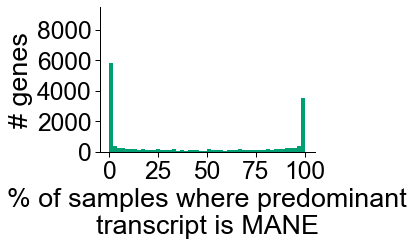

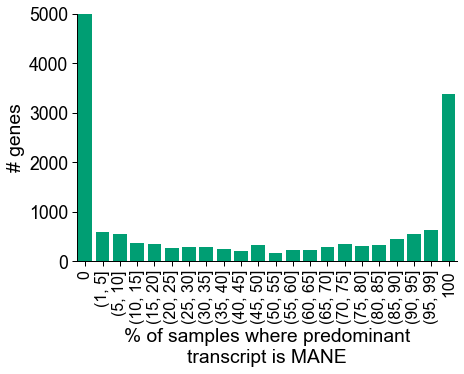

<Figure size 288x324 with 0 Axes>

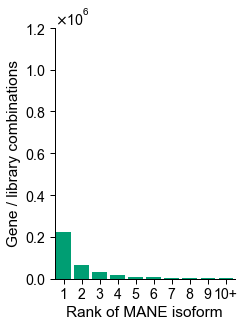

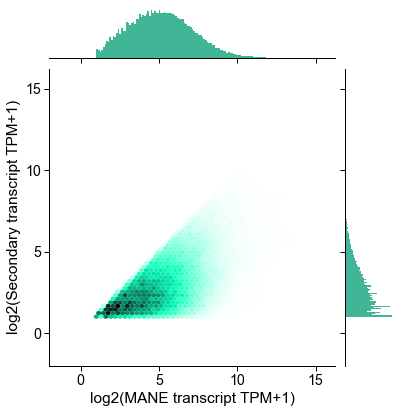

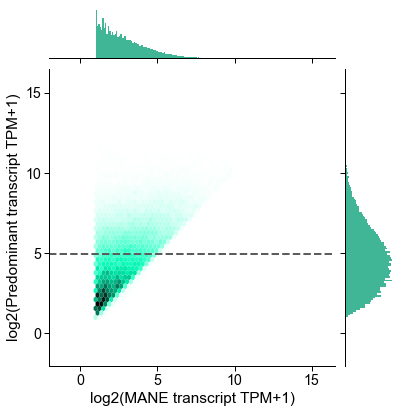

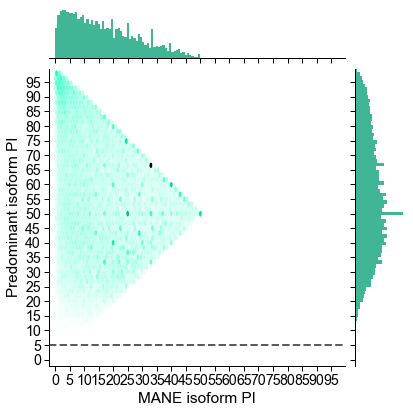

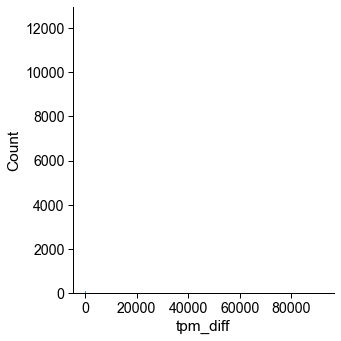

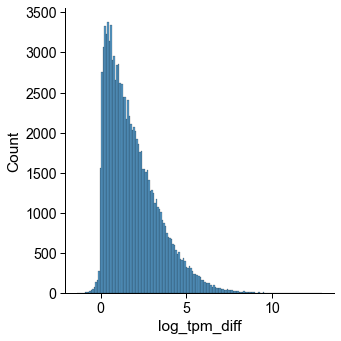

In [6]:
sg = swan.read(swan_file)
ca = cerberus.read(cerberus_h5)
mp_dfs = mane_analysis(sg, ca, 
                       ref_t_metadata,
                       ref_g_metadata,
                       'sample',
                       min_tpm,
                       sample_exp_gene,
                       config['lr']['mane']['pi_tpm'],
                       feats=['triplet'])